In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'handwriting-recognition:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F818027%2F1400106%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240425%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240425T044526Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6ec74d1f100967131e667c7bcfd5dd9cd2682f8ae3485ad86d80dcd526491fd791fe0f6432dbb7fa6306a6355fd3494e2b08a3d5bb868b5be5ba8dff1706a8f65bdc1d0ec607fba40585c6077558e525fdff4be478175cf88b62beeace98f6b05f23d733f291d3b344494803398b064449c1a3ddda0acda80438ddf3edfd575e2b28b1a10a497e1898287a70c10ddac3cb96272b19c5bcfeec0c99a29b67d523700a6ced9ef1c837e78bf31a7273eeea22a33fc53af189315f7698cb30241b33a94e060111131210b5c0a584760d1c665103dc68dba65431f2cda6daa686998872e0314dad39fe716a77f75aaa966ad16ec72b355bdef758a2e0887a9e71256d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1353071625 bytes downloaded
Downloaded and uncompressed: handwriting-recognition
Data source import complete.


In this notebook, we'll go through the steps to train a CRNN (CNN+RNN) model for handwriting recognition. The model will be trained using the CTC(Connectionist Temporal Classification) loss.




Lets start by importing the necessary libraries. I'll be using Keras for building our CRNN model.

In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

In [ ]:
# It is necessaryr for a TPU to be running to the amount of data we are processing

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.master())
except ValueError:
    print("Could not connect to TPU")
    tpu = None

# Select appropriate distribution strategy
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("Number of accelerators: ", strategy.num_replicas_in_sync)


Could not connect to TPU
Number of accelerators:  1


## Load and view data

In [ ]:
# Train and Validation Data
train = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_train_v2.csv')
valid = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_validation_v2.csv')

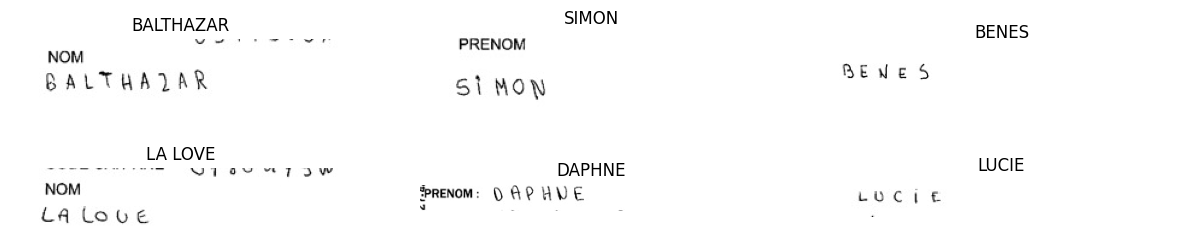

In [ ]:
# Plotting data to see form of data
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## Cleaning Data

Let's check for NaNs in our label.

In [ ]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [ ]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

Also, there are some images in our data with the label 'UNREADABLE'. Lets check those images and remove them.

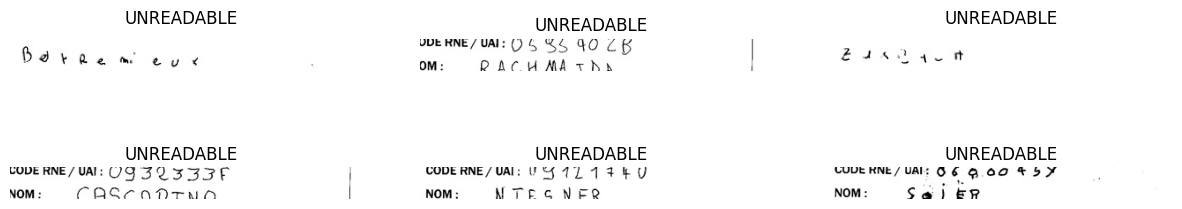

In [ ]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)
# Removal of UnReadable Data
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

There are some labels which are in lowercase. To maintain uniformity in the labels, I convert all the labels to uppercase.

In [ ]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

Reset the index and we are done with cleaning.

In [ ]:
train.reset_index(inplace = True, drop=True)
valid.reset_index(inplace = True, drop=True)

## Preprocessing and preparing the images for training

* The images are loaded as grayscale and reshaped to width 256 and height 64.  
* The width and height are cropped if they are greater than 256 and 64 respectively. If they are smaller, then the image is padded with white pixels. Finally the image is rotated clockwise to bring the image shape to (x, y).
* The image is then normalized to range [0, 1]

In [ ]:
def preprocess(img):
    (h, w) = img.shape

    final_img = np.ones([64, 256])*255 # blank white image

    # crop
    if w > 256:
        img = img[:, :256]

    if h > 64:
        img = img[:64, :]


    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

The model will be trained on 30000 images and validate on 3000 images

In [ ]:
train_size = 30000
valid_size= 3000

In [ ]:
# Train Data
train_x = []

for i in range(train_size):
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)


In [ ]:
# Validation Data
valid_x = []

for i in range(valid_size):
    img_dir = '/kaggle/input/handwriting-recognition/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [ ]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [ ]:
# Checking if size of train and valid are same of that of declared
print(len(train_x))
print(len(valid_x))

30000
3000


## Preparing the labels for CTC Loss

Learn more about CTC loss and why its amazing for text recognition from [here](https://theailearner.com/2019/05/29/connectionist-temporal-classificationctc/).

The labels have to be converted to numbers which represent each character in the training set. The 'alphabets' consist of A-Z and three special characters (-  '  and space).

In [ ]:
# Preparing for CTC Loss
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))

    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [ ]:
# Checking if labeling works
name = 'JEBASTIN'
print(name, '\n',label_to_num(name))

JEBASTIN 
 [ 9  4  1  0 18 19  8 13]


* **train_y** contains the true labels converted to numbers and padded with -1. The length of each label is equal to max_str_len.
* **train_label_len** contains the length of each true label (without padding)
* **train_input_len** contains the length of each predicted label. The length of all the predicted labels is constant i.e number of timestamps - 2.  
* **train_output** is a dummy output for ctc loss.


In [ ]:
# Sequence preprocessing
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])

In [ ]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])

In [ ]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100],
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


In [ ]:
from keras.models import load_model

# Load the model
model = load_model('/content/model.h5')

1/1 [==============================] - 4s 4s/step


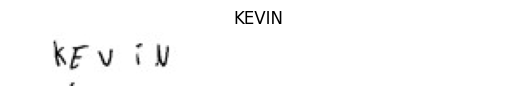

In [ ]:
# Testing with uploaded data
img_dir = '/content/TEST_0001.jpg'
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')

image = preprocess(image)
image = image/255.
pred = model.predict(image.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1],
                                    greedy=True)[0][0])
plt.title(num_to_label(decoded[0]), fontsize=12)
plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)


## Building our model


The output shape of the predictions is (64, 30). The model predicts words of 64 characters and each character contains the probability of the 30 alphabets which we defined earlier.  

In [ ]:
# Building the Model if model isn't present
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

In [ ]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [ ]:
from keras.models import load_model

# Load the model ( same as above)
model = load_model('my_model.h5')

## Train our model

In [ ]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))
model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output,
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=25, batch_size=128)
# Highly Recommended to use TPU to make this faster

## Check model performance on validation set

In [ ]:
# Assuming your model is named 'model'
# Saving model to reduce model creation time for further use
model.save('/content/model.h5')


In [ ]:
# storing both formats of the model file
model.save('/content/model.keras')


In [ ]:
# Prediction
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1],
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))
print(prediction)

94/94 [==============================] - 9s 99ms/step
['BILEL', 'LAUMONIER', 'LEA', 'JEAN-ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JENN-MICHEL', 'JULIEN', 'NAEL', 'NBILGER', 'TIFFANY', 'ELEEN', 'ANTOINE', 'AYOUD', 'MINETTE', 'RAINGEVAL', 'CELESTIN', 'DIBENEDETTO', 'MATHIS', 'LOUNA', 'SEVESTRE', 'DEVANLAY', 'HOCQUARD', 'LEBRUN', 'DABIN', 'SENDOUBI', 'DI PASQUAL', 'PRIVAT', 'HUGO', 'MAONI', 'COTTIGNY', 'SARRAZIN', 'FRERE', 'MONSOH', 'PELKERROUE', 'CLEMENT', 'ALLEMBRAND', 'CASSANDRA', 'VIEILLE', 'VAUTIER', 'LOUSSF', 'DURRNR', 'ENNIO', 'ALYSSIA', 'RUIZ', 'LIZANA', 'CAMILLE', 'JULIE', 'ELIA', 'AXFL', 'ANTOINE', 'NION', 'RICHAKD', 'COUNAC', 'DAVOULT', 'SHAD', 'DUBOIS', 'NAU', 'JULIEN', 'BENGT', 'DAUID', 'THOMAS', 'VAILLANT', 'JOAO', 'LYLOU', 'CARA', 'TABUT', 'PELLETIER', 'AUTRET', 'CHECROUN', 'VASSEUR', 'FAURE', 'EMMA', 'ARTHUR', 'FRIMIN', 'PNAELLE', 'QUEON', 'RAPHEL', 'VANTOMMF', 'ONNES', 'ANTOINE', 'ANDRANIK', 'LUCAS', 'CELIA', 'LOURENCO', 'MAYLIS', 'LUCIE', 'DEBARD', 'DEPAQUY', 'VERM

In [ ]:
# Checking Accuracy of the Model
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)

    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1

    if pr == tr :
        correct += 1


print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 89.94%
Correct words predicted      : 73.67%


## Some predictions on test set

1/1 [==============================] - 0s 70ms/step


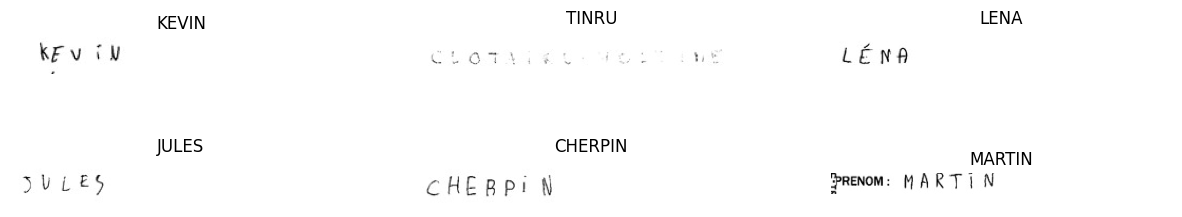

In [ ]:
# Predidctions on basis of Test Data
test = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')

    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1],
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
pip install pyttsx3

In [ ]:
!pip install gTTS



1/1 [==============================] - 0s 51ms/step


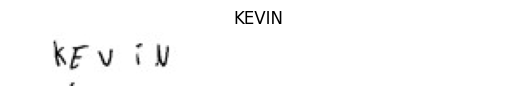

In [ ]:
# Prediction based on Uploaded Data
#ax = plt.subplot(2, 3, i+1)
img_dir = '/content/TEST_0001.jpg'
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')

image = preprocess(image)
image = image/255.
pred = model.predict(image.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1],
                                    greedy=True)[0][0])
plt.title(num_to_label(decoded[0]), fontsize=12)
plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
print(num_to_label(decoded[0]))
tts_word=num_to_label(decoded[0])

KEVIN


In [ ]:
import pyttsx3
def text_to_speech(text):
    """
    Converts text to speech using pyttsx3.
    """
    # Initialize the text-to-speech engine
    engine = pyttsx3.init()
    # Set properties (optional)
    # engine.setProperty('rate', 150)  # Speed of speech
    # engine.setProperty('volume', 0.9)  # Volume (0.0 to 1.0)
    # Convert text to speech
    engine.say(text)
    # Wait for speech to finish
    engine.runAndWait()

In [ ]:
from gtts import gTTS
from IPython.display import Audio

# Create a text-to-speech object with desired text
tts = gTTS(tts_word)

# Save to a temporary file and play in Google Colab
tts.save("tts_output.mp3")
Audio("tts_output.mp3")  # Play the audio


In [ ]:
# If not installed, install matplotlib
!pip install matplotlib


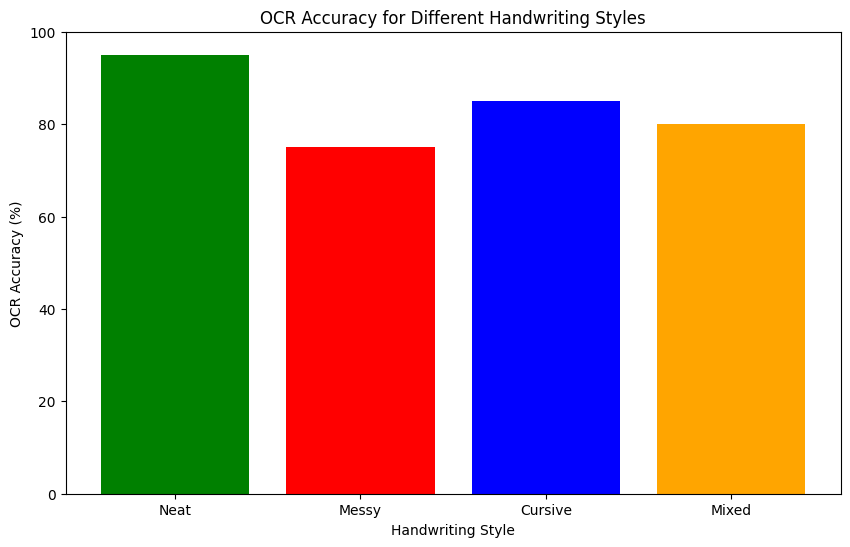

In [ ]:
import matplotlib.pyplot as plt

# Define the data again to avoid NameError
handwriting_styles = ["Neat", "Messy", "Cursive", "Mixed"]
ocr_accuracy = [95, 75, 85, 80]  # OCR accuracy for each handwriting style

# Customizing the graph
plt.figure(figsize=(10, 6))  # Set the size of the graph
plt.bar(handwriting_styles, ocr_accuracy, color=['green', 'red', 'blue', 'orange'])
plt.title("OCR Accuracy for Different Handwriting Styles")
plt.xlabel("Handwriting Style")
plt.ylabel("OCR Accuracy (%)")
plt.ylim(0, 100)  # Set the range for the y-axis
plt.show()  # Display the graph


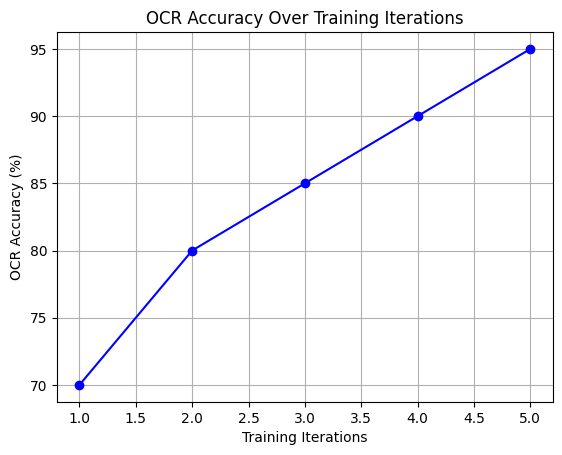

In [ ]:
# Sample data for a line graph
iterations = [1, 2, 3, 4, 5]
accuracy = [70, 80, 85, 90, 95]  # OCR accuracy over different iterations

import matplotlib.pyplot as plt

# Create a line graph
plt.plot(iterations, accuracy, marker='o', linestyle='-', color='b')
plt.title("OCR Accuracy Over Training Iterations")
plt.xlabel("Training Iterations")
plt.ylabel("OCR Accuracy (%)")
plt.grid(True)  # Add grid lines for easier reading
plt.show()  # Display the graph


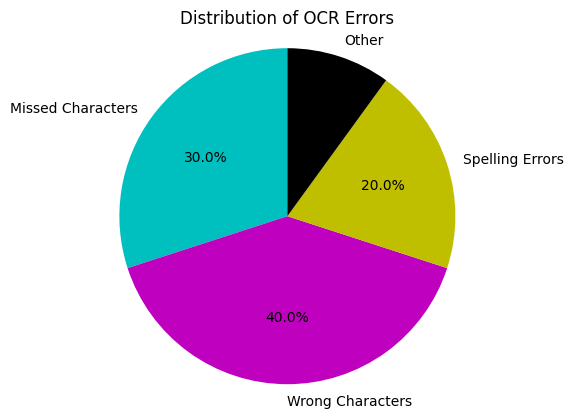

In [ ]:
# Sample data for a pie chart
error_types = ["Missed Characters", "Wrong Characters", "Spelling Errors", "Other"]
error_distribution = [30, 40, 20, 10]  # Proportions of different error types

import matplotlib.pyplot as plt

# Create a pie chart
plt.pie(error_distribution, labels=error_types, autopct='%1.1f%%', startangle=90, colors=['c', 'm', 'y', 'k'])
plt.title("Distribution of OCR Errors")
plt.axis('equal')  # Ensure the pie chart is a circle
plt.show()


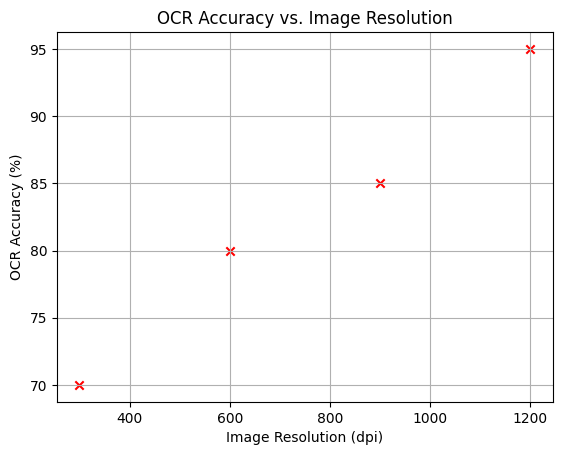

In [ ]:
# Sample data for a scatter plot
image_quality = [300, 600, 900, 1200]  # Image resolution in dpi
accuracy = [70, 80, 85, 95]  # OCR accuracy

import matplotlib.pyplot as plt

# Create a scatter plot
plt.scatter(image_quality, accuracy, color='r', marker='x')
plt.title("OCR Accuracy vs. Image Resolution")
plt.xlabel("Image Resolution (dpi)")
plt.ylabel("OCR Accuracy (%)")
plt.grid(True)  # Add grid lines
plt.show()  # Display the scatter plot


## Ways to improve the model

* Use more training samples. This will help the model to learn and generalise better. I have used only 10% of the images as the entire training set cannot be loaded into kaggle's memory.
* There are multiple images in the training set which are not at all legible to the human eye. Removing such images will help in model's learning.